## <b>Описание данных и задания </b>

### <b>Техническое задание </b>

#### <b>Описание</b>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

#### toxic_comments.csv

●text - содержит текст комментария.
<br>●toxic — целевой признак.

Aлгоритм решения:
<br>●Загрузить и подготовь данные.
<br>●Обучить разные модели.
<br>●Сделайть выводы.

## <b>Импорт библиотек и функций</b>

#### <b>Библиотеки</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import time
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### <b>Функции</b>

In [2]:
line = '-'*132
def percentage_passes (dataset):
    print(dataset.info())
    print(line)
    print('Количество пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.sum(dataset[col].isnull())
        print(col, datcol)  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())

def radial_diagram (variable, column):
    variable[column].value_counts().plot(y='subscription_type', kind='pie',figsize=(6,6), autopct='%1.1f%%')
    mp.title(f'Диаграмма для - {column}')
    mp.ylabel("")
    mp.show()

def graph_analis(true, predict):
    sns.set()
    f1 = f1_score(y_test, predict)
    plt.figure(figsize=(7,4))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2)
    plt.title('Плотности предсказанных и истинных значений', y=1)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

## <b>Загрузка и изучение данных</b>

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
percentage_passes(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
Unnamed: 0 0
text 0
toxic 0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 0


Столбец "Unnamed: 0" переведу в индекс датасета.

In [6]:
data.rename(columns = {'Unnamed: 0': 'index'}, inplace = True)

In [7]:
data = data.set_index('index')

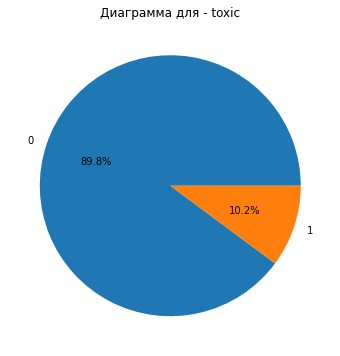

In [8]:
radial_diagram(data, 'toxic')

<b>Вывод</b>
<br>Таблица содержит 159292 строк, дубликатов и пропусков нет. Целевое значение 1(токсичный коментарий) занимает всего 10% таблицы.

## <b>Очистка и лематизация текста</b>

In [9]:
def postag(penntag):
    tags = nltk.pos_tag([penntag])[0][1][0].upper()
    tags_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tags_dict.get(tags, wordnet.NOUN)

sentence = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, postag(w)) for w in nltk.word_tokenize(sentence)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [10]:
#Функция POS тега
def postag(penntag):
    tags = nltk.pos_tag([penntag])[0][1][0].upper()
    tags_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tags_dict.get(tags, wordnet.NOUN)
#Лематизация и очистка 
def new_text(text):
    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
    words = nltk.word_tokenize(clean)
    lemmatized = ' '.join([lemmatizer.lemmatize(w, pos=postag(w)) for w in words])    
    return lemmatized

In [11]:
data['lemmatize'] = data['text'].apply(new_text)

In [12]:
data.head()

,text,toxic,lemmatize
index,,,
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Текст успешно очищен и лематизирован.

## <b>Подготовка к обучению</b>

In [13]:
X = data.drop('toxic', axis=1)
y = data.toxic

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state = 42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, random_state = 42, stratify=y_test_and_val)

print(f"Строк в тренировочном датасете - {len(X_train)}") 
print(line)
print(f"Строк в валидационном датасете - {len(X_val)}")
print(line)
print(f"Строк в тестовом датасете - {len(X_test)}")

Строк в тренировочном датасете - 79646
------------------------------------------------------------------------------------------------------------------------------------
Строк в валидационном датасете - 39823
------------------------------------------------------------------------------------------------------------------------------------
Строк в тестовом датасете - 39823


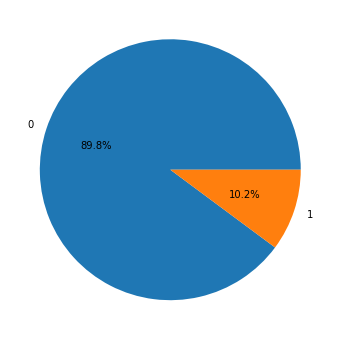

------------------------------------------------------------------------------------------------------------------------------------


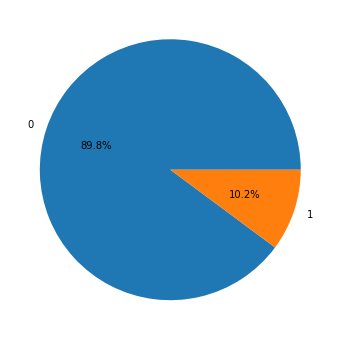

------------------------------------------------------------------------------------------------------------------------------------


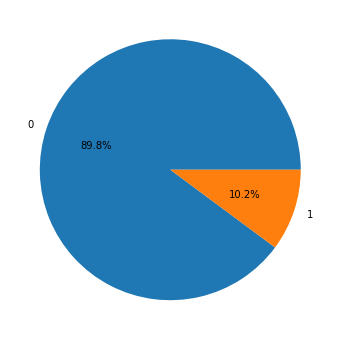

In [14]:
y_train.value_counts().plot(y='subscription_type', kind='pie',figsize=(6,6), autopct='%1.1f%%')
mp.ylabel("")
mp.show()
print(line)
y_val.value_counts().plot(y='subscription_type', kind='pie',figsize=(6,6), autopct='%1.1f%%')
mp.ylabel("")
mp.show()
print(line)
y_test.value_counts().plot(y='subscription_type', kind='pie',figsize=(6,6), autopct='%1.1f%%')
mp.ylabel("")
mp.show()

Применю TF-IDF 

In [15]:
tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = tf_idf.fit_transform(X_train['lemmatize'])
tf_idf_val = tf_idf.transform(X_val['lemmatize'])
tf_idf_test = tf_idf.transform(X_test['lemmatize'])

print(tf_idf_train.shape)
print(tf_idf_val.shape)
print(tf_idf_test.shape)

(79646, 101662)
(39823, 101662)
(39823, 101662)


<b>Вывод</b>
<br>Данные разделены на тренировочную и тестовую выборку а также обработал текст с помощью TF-IDF.

## <b>Обучение</b>

In [17]:
start = time.time()
LR = LogisticRegression()

LR.fit(tf_idf_train, y_train) 

pred_LR = LR.predict(tf_idf_val)

f1_LR = f1_score(y_val, pred_LR) 
print('Метрика f1 для LogisticRegression -', f1_LR.round(2))
end = time.time()
total_time = end - start
print('Время обучения и предсказания LogisticRegression', total_time)
print(line)

start = time.time()
RFC = RandomForestClassifier()

RFC.fit(tf_idf_train, y_train) 

pred_RFC = RFC.predict(tf_idf_val)

f1_RFC = f1_score(y_val, pred_RFC) 
print('Метрика f1 для RandomForestClassifier -', f1_RFC.round(2))
end = time.time()
total_time = end - start
print('Время обучения и предсказания RandomForestClassifier', total_time)
print(line)

start = time.time()
DTCL = DecisionTreeClassifier()

DTCL.fit(tf_idf_train, y_train) 

pred_DTCL = DTCL.predict(tf_idf_val)

f1_DTCL = f1_score(y_val, pred_DTCL) 
print('Метрика f1 для RandomForestClassifier -', f1_DTCL.round(2))
end = time.time()
total_time = end - start
print('Время обучения и предсказания DecisionTreeClassifier', total_time)
print(line)

start = time.time()
LGBMCl = LGBMClassifier()

LGBMCl.fit(tf_idf_train, y_train) 

pred_LGBMCl = LGBMCl.predict(tf_idf_val)

f1_LGBMCl = f1_score(y_val, pred_LGBMCl) 
print('Метрика f1 для LGBMClassifier -', f1_LGBMCl.round(2))
end = time.time()
total_time = end - start
print('Время обучения и предсказания LGBMClassifier', total_time)
print(line)

start = time.time()
CBCL = CatBoostClassifier()

CBCL.fit(tf_idf_train, y_train) 

pred_CBCL = CBCL.predict(tf_idf_val)

f1_CBCL = f1_score(y_val, pred_CBCL) 
print('Метрика f1 для CatBoostClassifier -', f1_CBCL.round(2))
end = time.time()
total_time = end - start
print('Время обучения и предсказания CatBoostClassifier', total_time)

Метрика f1 для LogisticRegression - 0.71
Время обучения и предсказания LogisticRegression 46.56608557701111
------------------------------------------------------------------------------------------------------------------------------------
Метрика f1 для RandomForestClassifier - 0.69
Время обучения и предсказания RandomForestClassifier 282.20703506469727
------------------------------------------------------------------------------------------------------------------------------------
Метрика f1 для RandomForestClassifier - 0.71
Время обучения и предсказания DecisionTreeClassifier 221.4051637649536
------------------------------------------------------------------------------------------------------------------------------------
Метрика f1 для LGBMClassifier - 0.74
Время обучения и предсказания LGBMClassifier 761.1945028305054
------------------------------------------------------------------------------------------------------------------------------------
Learning rate set to 0.0667

Лучше всего стправились 2 модели CatBoostClassifier и LGBMClassifier. LGBMClassifier обучилась намного быстрее, но у CatBoostClassifier больше метрика.

Проверю как эти модели справились со своей задачей.

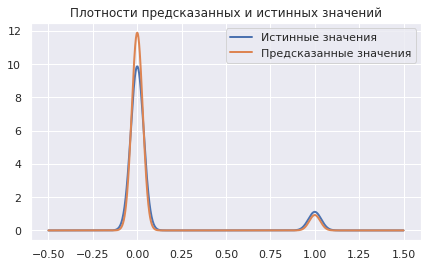

------------------------------------------------------------------------------------------------------------------------------------


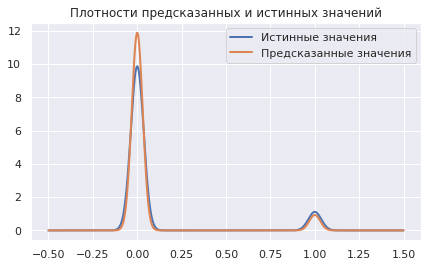

In [18]:
graph_analis(y_val,pred_CBCL)
print(line)
graph_analis(y_val,pred_LGBMCl)

Графики смотрятся одинаково.

Протестирую CatBoostClassifier на тестовой выборке.

In [19]:
pred_CBCL = CBCL.predict(tf_idf_test)

f1_CBCL = f1_score(y_test, pred_CBCL) 
print('Метрика f1 для CatBoostClassifier -', f1_CBCL.round(2))

Метрика f1 для CatBoostClassifier - 0.75


Метрика получилась как и при тестировании на валидации.

## <b>Общий вывод</b>

Желательно увеличить выборку токсичных коментариев для достижения более лучшего результата.
<br>В процессе текст был очищен и лематизирован с помощью WordNetLemmatizer а так-же трансформирован с помощью TF-IDF. 
<br>Таблица была разделена на 3 части:
<br>train - 79646 строк.
<br>valid и test по 39823 строк.
<br>Были обучены и протестированы (на валидации) 5 моделей - LogisticRegression, RandomForestClassifier,DecisionTreeClassifier, LGBMClassifier и CatBoostClassifier. Лучшей моделью с метрике f1 оказалась CatBoostClassifier с показателем 0.75 такой-же показатель модель показала и на тестовой выборке